In [1]:
import pandas as pd

In [18]:
sp500 = pd.read_csv("sp500.csv", index_col="Date")

sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,0,0
1950-01-04,16.85,16.85,16.85,16.85,1890000,0,0
1950-01-05,16.93,16.93,16.93,16.93,2550000,0,0
1950-01-06,16.98,16.98,16.98,16.98,2010000,0,0
1950-01-09,17.08,17.08,17.08,17.08,2520000,0,0


In [19]:
# sp500.index = pd.to_datetime(sp500.Date)


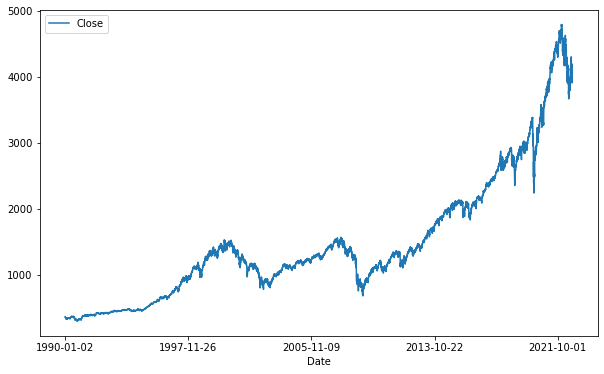

In [35]:
sp500.plot.line(y="Close", use_index=True, figsize=(10,6));

In [21]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [22]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [23]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [24]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,16.850000
1950-01-04,16.85,16.85,16.85,16.85,1890000,16.930000
1950-01-05,16.93,16.93,16.93,16.93,2550000,16.980000
1950-01-06,16.98,16.98,16.98,16.98,2010000,17.080000
1950-01-09,17.08,17.08,17.08,17.08,2520000,17.030001


In [25]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,16.850000,1
1950-01-04,16.85,16.85,16.85,16.85,1890000,16.930000,1
1950-01-05,16.93,16.93,16.93,16.93,2550000,16.980000,1
1950-01-06,16.98,16.98,16.98,16.98,2010000,17.080000,1
1950-01-09,17.08,17.08,17.08,17.08,2520000,17.030001,0


In [26]:
sp500 = sp500.loc["1990-01-01":].copy()

sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

In [28]:
train.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


In [29]:
test.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2022-04-20,4472.259766,4488.290039,4448.759766,4459.450195,3678040000,4393.660156,0
2022-04-21,4489.169922,4512.939941,4384.470215,4393.660156,3833570000,4271.779785,0
2022-04-22,4385.830078,4385.830078,4267.620117,4271.779785,3930660000,4296.120117,1
2022-04-25,4255.339844,4299.020020,4200.819824,4296.120117,4061070000,4175.200195,0
2022-04-26,4278.140137,4278.140137,4175.040039,4175.200195,3760420000,4183.959961,1


In [30]:
predictors = ["Close", "Volume", "Open", "High", "Low"]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [31]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index= test.index)
precision_score(test["Target"], preds)

0.47058823529411764

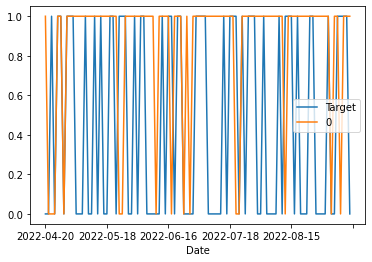

In [32]:
combined = pd.concat([test["Target"], preds], axis=1)

combined.plot();

In [33]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [36]:
def backtest(data, model, predictors, start = 2500, step=250):
    all_predictions = [ ]

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

    

In [37]:
predictions =backtest(sp500, model, predictors)

In [38]:
predictions["Predictions"].value_counts()

0    3337
1    2401
Name: Predictions, dtype: int64

In [39]:
precision_score(predictions["Target"], predictions["Predictions"])

0.534777176176593

In [40]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.536075
0    0.463925
Name: Target, dtype: float64

In [41]:
horizons = [2,5,60,250,1000]
new_predictors = [ ]


for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [42]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [44]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0


In [45]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [46]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index= test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [47]:
predictions = backtest(sp500, model, new_predictors)

In [48]:
predictions["Predictions"].value_counts()

0.0    3933
1.0     805
Name: Predictions, dtype: int64

In [49]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5701863354037268

In [50]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.546855
0    0.453145
Name: Target, dtype: float64

In [51]:
predictions.head()

,Target,Predictions
Date,,
2003-11-14,0,0.0
2003-11-17,0,1.0
2003-11-18,1,1.0
2003-11-19,0,0.0
2003-11-20,1,1.0
